## Student Mental Health Analysis using Hybrid Model Structure ( FCM & KNN)


---

***1. Cluster Formation with Fuzzy C-Means (FCM):***

**Purpose:** To group students into clusters based on their mental health characteristics (e.g., levels of depression, anxiety, and panic attacks) and possibly other factors like CGPA and age.

**Outcome:** Each student is assigned a degree of membership to each cluster, indicating how strongly they belong to potential groups identified by FCM.

***2. Prediction with K-Nearest Neighbors (KNN):***

**Purpose:** Utilize the cluster memberships as features in a KNN model to predict outcomes, such as the likelihood of seeking specialist treatment or the severity of mental health issues.

**Integration:** Use the membership values from FCM as input features for KNN, alongside other relevant attributes. This provides a richer feature set that includes both raw data and derived cluster-based insights.

Step 1: Import Libraries and Load the Dataset

In [71]:
!pip install scikit-fuzzy

In [72]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skfuzzy.cluster import cmeans
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
file_path = "Student Mental health.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Check for missing values and data types
print("\nDataset Information:")
print(data.info())


Dataset Preview:
        Timestamp Choose your gender   Age What is your course?  \
0  8/7/2020 12:02             Female  18.0          Engineering   
1  8/7/2020 12:04               Male  21.0    Islamic education   
2  8/7/2020 12:05               Male  19.0                  BIT   
3  8/7/2020 12:06             Female  22.0                 Laws   
4  8/7/2020 12:13               Male  23.0         Mathemathics   

  Your current year of Study What is your CGPA? Marital status  \
0                     year 1        3.00 - 3.49             No   
1                     year 2        3.00 - 3.49             No   
2                     Year 1        3.00 - 3.49             No   
3                     year 3        3.00 - 3.49            Yes   
4                     year 4        3.00 - 3.49             No   

  Do you have Depression? Do you have Anxiety? Do you have Panic attack?  \
0                     Yes                   No                       Yes   
1                      No      

Step 2: Preprocess the Data

In [73]:
# Checking for missing values in the dataset
missing_data_summary = data.isnull().sum()

missing_data_summary


,0
Timestamp,0
Choose your gender,0
Age,1
What is your course?,0
Your current year of Study,0
What is your CGPA?,0
Marital status,0
Do you have Depression?,0
Do you have Anxiety?,0
Do you have Panic attack?,0


In [74]:
# Impute missing values in 'Age' with the median
median_age = data['Age'].median()
data['Age'].fillna(median_age, inplace=True)

# Check if the missing value has been filled
data.isnull().sum()


<ipython-input-74-9be49bdde733>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(median_age, inplace=True)


,0
Timestamp,0
Choose your gender,0
Age,0
What is your course?,0
Your current year of Study,0
What is your CGPA?,0
Marital status,0
Do you have Depression?,0
Do you have Anxiety?,0
Do you have Panic attack?,0


In [75]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Creating instance of labelencoder for ordinal variables
label_encoder = LabelEncoder()

# Label encoding for 'Your current year of Study'
# Check if the column is already numeric (encoded)
if data['Your current year of Study'].dtype == object:  # Only encode if it's string type
    year_order = ['year 1', 'Year 1', 'year 2', 'year 3', 'year 4']  # Assumed typical order
    data['Your current year of Study'] = label_encoder.fit_transform(
        data['Your current year of Study'].apply(lambda x: x.strip().lower())
    )

# Label encoding for 'What is your CGPA?' assuming ordinal nature
cgpa_order = ['Below 2.00', '2.00 - 2.49', '2.50 - 2.99', '3.00 - 3.49', '3.50 - 4.00']
data['What is your CGPA?'] = label_encoder.fit_transform(
    data['What is your CGPA?']
)

# One-hot encoding for nominal variables
nominal_vars = ['Choose your gender', 'What is your course?', 'Marital status',
                'Do you have Depression?', 'Do you have Anxiety?', 'Do you have Panic attack?',
                'Did you seek any specialist for a treatment?']
data_encoded = pd.get_dummies(data, columns=nominal_vars)

# Display the encoded dataset
data_encoded.head()

,Timestamp,Age,Your current year of Study,What is your CGPA?,Choose your gender_Female,Choose your gender_Male,What is your course?_ALA,What is your course?_Accounting,What is your course?_BCS,What is your course?_BENL,...,Marital status_No,Marital status_Yes,Do you have Depression?_No,Do you have Depression?_Yes,Do you have Anxiety?_No,Do you have Anxiety?_Yes,Do you have Panic attack?_No,Do you have Panic attack?_Yes,Did you seek any specialist for a treatment?_No,Did you seek any specialist for a treatment?_Yes
0,8/7/2020 12:02,18.0,0,3,True,False,False,False,False,False,...,True,False,False,True,True,False,False,True,True,False
1,8/7/2020 12:04,21.0,1,3,False,True,False,False,False,False,...,True,False,True,False,False,True,True,False,True,False
2,8/7/2020 12:05,19.0,0,3,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,True,False
3,8/7/2020 12:06,22.0,2,3,True,False,False,False,False,False,...,False,True,False,True,True,False,True,False,True,False
4,8/7/2020 12:13,23.0,3,3,False,True,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False


Step 3 : Nomalizing the Data

In [76]:
from sklearn.preprocessing import MinMaxScaler

# Initializing the MinMaxScaler
scaler = MinMaxScaler()

# Columns to be normalized
numerical_cols = ['Age', 'Your current year of Study', 'What is your CGPA?']

# Applying MinMaxScaler to the dataset
data_encoded[numerical_cols] = scaler.fit_transform(
    data_encoded[numerical_cols]
)

# Display the normalized dataset
data_encoded.head()


,Timestamp,Age,Your current year of Study,What is your CGPA?,Choose your gender_Female,Choose your gender_Male,What is your course?_ALA,What is your course?_Accounting,What is your course?_BCS,What is your course?_BENL,...,Marital status_No,Marital status_Yes,Do you have Depression?_No,Do you have Depression?_Yes,Do you have Anxiety?_No,Do you have Anxiety?_Yes,Do you have Panic attack?_No,Do you have Panic attack?_Yes,Did you seek any specialist for a treatment?_No,Did you seek any specialist for a treatment?_Yes
0,8/7/2020 12:02,0.000000,0.000000,0.6,True,False,False,False,False,False,...,True,False,False,True,True,False,False,True,True,False
1,8/7/2020 12:04,0.500000,0.333333,0.6,False,True,False,False,False,False,...,True,False,True,False,False,True,True,False,True,False
2,8/7/2020 12:05,0.166667,0.000000,0.6,False,True,False,False,False,False,...,True,False,False,True,False,True,False,True,True,False
3,8/7/2020 12:06,0.666667,0.666667,0.6,True,False,False,False,False,False,...,False,True,False,True,True,False,True,False,True,False
4,8/7/2020 12:13,0.833333,1.000000,0.6,False,True,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False


Step 4 : Implement Fuzzy C-Means Clustering (FCM)

---

*   Select features relevant for mental health clustering.
*  Determine the optimal number of clusters using validation techniques like the silhouette score.
*   Run FCM to get membership values for each cluster for every student.






In [77]:
import skfuzzy as fuzz
import numpy as np

# Selecting relevant features for clustering
features_for_clustering = data_encoded[['Age', 'What is your CGPA?',
    'Do you have Depression?_Yes', 'Do you have Anxiety?_Yes', 'Do you have Panic attack?_Yes']].values

# Number of clusters
n_clusters = 3

# Display the data types of the features intended for clustering
print(features_for_clustering.astype(float))

# Convert all columns to float if not already
features_for_clustering = features_for_clustering.astype(float)

# Now try running the Fuzzy C-Means clustering again
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    data=features_for_clustering.T,  # Transpose the data to match expected format
    c=n_clusters,  # Number of clusters
    m=2,  # Fuzziness parameter
    error=0.005,  # Stopping criterion for optimization
    maxiter=1000,  # Maximum number of iterations
    init=None  # No initial guess for cluster centers
)

# Labels for each point
labels = np.argmax(u, axis=0)

# Displaying the cluster centers and the first few memberships
cluster_centers = cntr
memberships = u[:, :5]  # Displaying memberships for the first five points

(cluster_centers, memberships)


[[0.         0.6        1.         0.         1.        ]
 [0.5        0.6        0.         1.         0.        ]
 [0.16666667 0.6        1.         1.         1.        ]
 [0.66666667 0.6        1.         0.         0.        ]
 [0.83333333 0.6        0.         0.         0.        ]
 [0.16666667 0.8        0.         0.         1.        ]
 [0.83333333 1.         1.         0.         1.        ]
 [0.         0.8        0.         1.         0.        ]
 [0.16666667 0.4        0.         0.         0.        ]
 [0.         0.8        0.         1.         1.        ]
 [0.33333333 0.8        0.         0.         0.        ]
 [1.         0.8        1.         0.         0.        ]
 [0.         0.6        1.         0.         0.        ]
 [0.16666667 0.6        0.         0.         0.        ]
 [0.         0.8        0.         1.         0.        ]
 [1.         0.8        0.         0.         0.        ]
 [1.         0.6        0.         0.         0.        ]
 [1.         0

(array([[0.40678195, 0.64901698, 0.07012177, 0.08278455, 0.06044636],
        [0.48763344, 0.66679576, 0.3693261 , 0.23109858, 0.71790052],
        [0.30072605, 0.67109793, 0.73223226, 0.78706764, 0.34345065]]),
 array([[0.19742692, 0.35125776, 0.1267402 , 0.34023938, 0.7305652 ],
        [0.49093694, 0.24239559, 0.28545975, 0.32058977, 0.1760181 ],
        [0.31163614, 0.40634665, 0.58780005, 0.33917085, 0.0934167 ]]))

In [78]:
membership_matrix = u.T

# Assign each student to the cluster with the highest membership value
cluster_assignments = np.argmax(membership_matrix, axis=1)

# Create a DataFrame to store membership values and cluster assignments
membership_df = pd.DataFrame(membership_matrix, columns=[f"Cluster_{i+1}" for i in range(n_clusters)])
membership_df['Assigned_Cluster'] = cluster_assignments

# Display the first few rows of the membership DataFrame
membership_df.head()

,Cluster_1,Cluster_2,Cluster_3,Assigned_Cluster
0,0.197427,0.490937,0.311636,1
1,0.351258,0.242396,0.406347,2
2,0.126740,0.285460,0.587800,2
3,0.340239,0.320590,0.339171,0
4,0.730565,0.176018,0.093417,0


Cluster Risk Levels:
Cluster 3 (Risk Level: 0.62) - Rank 1
Cluster 2 (Risk Level: 0.44) - Rank 2
Cluster 1 (Risk Level: 0.07) - Rank 3


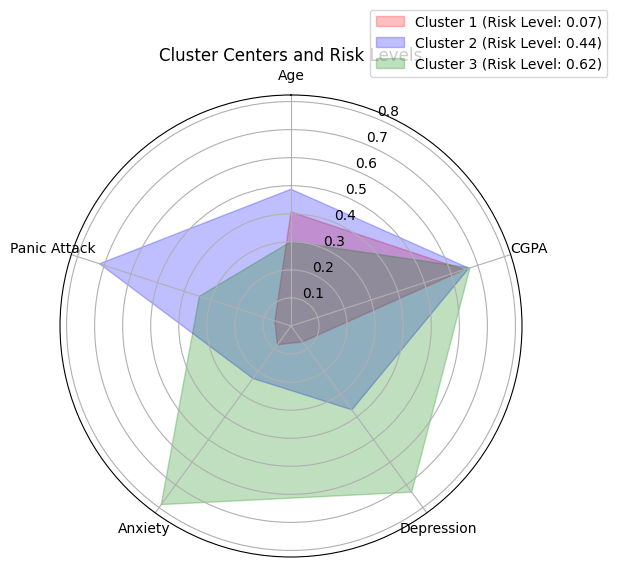

In [79]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'cntr' is your array of cluster centers
cluster_centers = cntr
num_vars = cluster_centers.shape[1]

# Labels for the features
labels = np.array(['Age', 'CGPA', 'Depression', 'Anxiety', 'Panic Attack'])

# Risk-related indices in the cluster center array
risk_indices = [2, 3, 4]  # Indices corresponding to 'Depression', 'Anxiety', 'Panic Attack'

# Calculate the "risk level" for each cluster as the average of risk-related features
cluster_risks = cluster_centers[:, risk_indices].mean(axis=1)

# Rank clusters by risk level
risk_ranking = np.argsort(cluster_risks)[::-1]  # Sort descending
cluster_labels = [f"Cluster {i + 1} (Risk Level: {cluster_risks[i]:.2f})" for i in range(len(cluster_risks))]

# Print the risk levels and ranking
print("Cluster Risk Levels:")
for i, rank in enumerate(risk_ranking):
    print(f"{cluster_labels[rank]} - Rank {i + 1}")

# Create a radar chart
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
colors = ['red', 'blue', 'green']  # Adjust colors as needed
for i, color in enumerate(colors):
    ax.fill(
        angles + angles[:1],
        cluster_centers[i].tolist() + cluster_centers[i].tolist()[:1],
        color=color,
        alpha=0.25,
        label=cluster_labels[i]
    )

# Beautify the plot
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axis per variable and add labels
plt.xticks(angles, labels)

# Add legend and title
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))
plt.title('Cluster Centers and Risk Levels')

plt.show()


Step 5 : Prepare Features for KNN:

---

*   Incorporate FCM membership values into the dataset.
*   Select and possibly engineer additional features for predicting your target variable (e.g., seeking treatment).

In [80]:
from sklearn.model_selection import train_test_split

# Incorporate FCM membership values into the dataset
# Assuming 'data_encoded' is your dataset with features and 'membership_df' contains FCM membership values
enriched_data = data_encoded.copy()
membership_features = membership_df[[f"Cluster_{i+1}" for i in range(n_clusters)]]
enriched_data = pd.concat([enriched_data, membership_features], axis=1)

# Define target variable (e.g., 'Did you seek any specialist for a treatment?_Yes')
target_variable = 'Did you seek any specialist for a treatment?_Yes'
features = enriched_data.drop(columns=[target_variable])  # Drop target variable from features
target = enriched_data[target_variable]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Display the shapes of the datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((70, 67), (31, 67), (70,), (31,))

Step 6 : Build and Train the KNN Model

In [81]:
# Drop non-numeric columns
non_numeric_columns = ['Timestamp']  # Add other non-numeric columns if necessary
X_train = X_train.drop(columns=non_numeric_columns, errors='ignore')
X_test = X_test.drop(columns=non_numeric_columns, errors='ignore')

# Ensure all features are numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Verify there are no missing values after conversion
print("Missing values in X_train after conversion:", X_train.isnull().sum().sum())
print("Missing values in X_test after conversion:", X_test.isnull().sum().sum())

# Proceed with GridSearchCV for KNN
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()  # KNN model
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
grid_search.fit(X_train, y_train)  # Fit the model to find the best k

# Extract the best k value
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

# Train the KNN model with the best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

Missing values in X_train after conversion: 0
Missing values in X_test after conversion: 0


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best k value: 1


KNeighborsClassifier(n_neighbors=1)

Step 7 : Evaluate and Optimize


In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.97
Precision: 1.00
Recall: 0.50
F1-Score: 0.67
Confusion Matrix:
[[29  0]
 [ 1  1]]


Step 8 : Visualization and Interpretation:



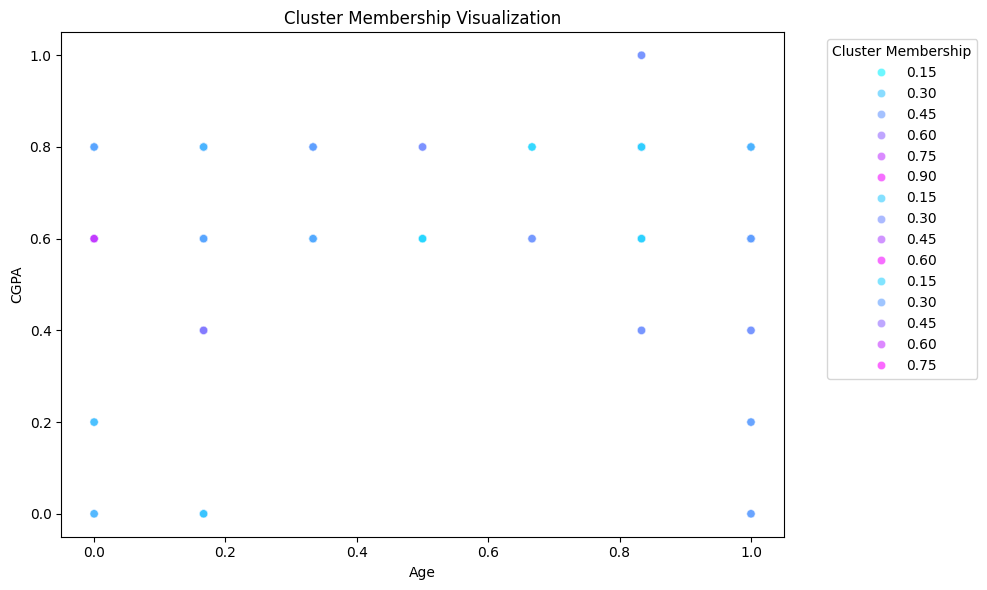

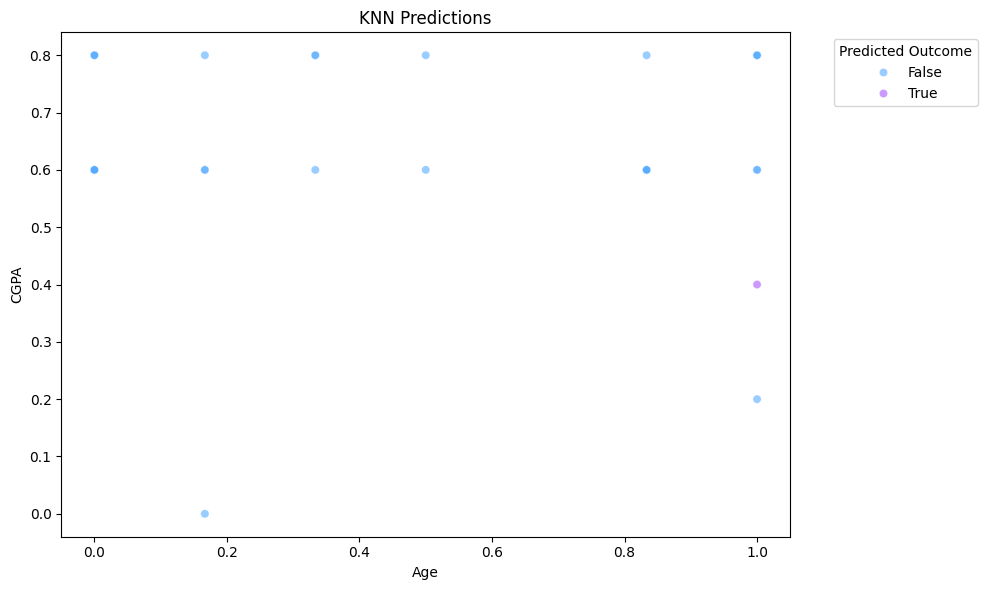

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the cluster membership
plt.figure(figsize=(10, 6))  # Adjust the figure size for better visibility

for i in range(n_clusters):
    sns.scatterplot(
        x=features['Age'],
        y=features['What is your CGPA?'],
        hue=membership_df[f'Cluster_{i+1}'],
        palette='cool',
        alpha=0.6
    )

plt.title("Cluster Membership Visualization")
plt.xlabel("Age")
plt.ylabel("CGPA")

# Move the legend outside the plot
plt.legend(
    title=f"Cluster Membership",
    bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
    loc='upper left'           # Position the legend in the upper-left corner
)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Visualize the predictions
plt.figure(figsize=(10, 6))  # Adjust the figure size

sns.scatterplot(
    x=X_test['Age'],
    y=X_test['What is your CGPA?'],
    hue=y_pred,
    palette='cool',
    alpha=0.6
)

plt.title("KNN Predictions")
plt.xlabel("Age")
plt.ylabel("CGPA")

# Move the legend outside the plot
plt.legend(
    title="Predicted Outcome",
    bbox_to_anchor=(1.05, 1),  # Place the legend outside the plot
    loc='upper left'           # Position the legend in the upper-left corner
)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [84]:
# Assuming 'features' contains all features before cluster membership is added
original_features = features.drop(columns=[f"Cluster_{i+1}" for i in range(n_clusters)], errors='ignore')
# Now original_features holds the data before cluster membership was added

# Ensure that all features used in KNN are numeric
original_features_numeric = original_features.select_dtypes(include=[float, int])

# Split into train and test sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    original_features_numeric, target, test_size=0.3, random_state=42
)

# Train KNN without cluster membership
knn_without_clusters = KNeighborsClassifier(n_neighbors=best_k)
knn_without_clusters.fit(X_train_original, y_train_original)
y_pred_without_clusters = knn_without_clusters.predict(X_test_original)

# Train KNN with cluster membership (no changes needed here since we already ensured features are numeric)
knn_with_clusters = KNeighborsClassifier(n_neighbors=best_k)
knn_with_clusters.fit(X_train, y_train)
y_pred_with_clusters = knn_with_clusters.predict(X_test)

# Compare performance
from sklearn.metrics import classification_report

print("Performance Without Cluster Membership:")
print(classification_report(y_test_original, y_pred_without_clusters))

print("\nPerformance With Cluster Membership:")
print(classification_report(y_test, y_pred_with_clusters))


Performance Without Cluster Membership:
              precision    recall  f1-score   support

       False       0.93      0.93      0.93        29
        True       0.00      0.00      0.00         2

    accuracy                           0.87        31
   macro avg       0.47      0.47      0.47        31
weighted avg       0.87      0.87      0.87        31


Performance With Cluster Membership:
              precision    recall  f1-score   support

       False       0.97      1.00      0.98        29
        True       1.00      0.50      0.67         2

    accuracy                           0.97        31
   macro avg       0.98      0.75      0.82        31
weighted avg       0.97      0.97      0.96        31

